<h1> Projeto de roteirização de coordendas</h1>
<br>
Por Fabio Benevides
<br>
Atualizado em 15.11.21

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import radians, cos, sin, asin, sqrt
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
import folium

# Importando as coordendas

In [2]:
df = pd.read_excel('paises.xlsx')
df.columns = df.columns.str.upper()

# Calculo das distancias dos defeitos para ponto de partida

In [3]:
def haversine(lat1, lon1, lat2, lon2):

    
    # Raio da Terra em quilometros é 6371
    r = 6371
    # Converte graus decimal para radiano 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Formula de Haversine 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    hav = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    d = 2 * r * asin( sqrt(hav) ) 
   
    return d


dist = []
for i in range(0,len(df)):
    g = round(haversine(df.LAT[i],df.LON[i], df.LAT[df['PONTO'] == df.PONTO[0]], df.LON[df['PONTO'] == df.PONTO[0]]),2) #calcula as distâncias entre cada ponto com o pornto de partida
    dist.append(g)

df['DIST_PARTIDA'] = dist

In [4]:
# calcular distancias entre todos os pontos
def calcula_matriz_distancias(frame_coordendas):

    x = frame_coordendas['LAT'].reset_index(drop=True)
    y = frame_coordendas['LON'].reset_index(drop=True)
    n = frame_coordendas.shape[0]
    s = (frame_coordendas.shape[0], frame_coordendas.shape[0])
    matriz_distancias = np.zeros(s, dtype=float)
    ponto_partida = frame_coordendas['DIST_PARTIDA'].min()

    for i in range(matriz_distancias.shape[0]):
          for j in range(matriz_distancias.shape[0]):
            matriz_distancias [i][j] = round(haversine(x[i],y[i], x[j], y[j]),2)

    return matriz_distancias


def create_data_model():
    data = {}
    data['distance_matrix'] = matriz_distancias
    data['num_vehicles'] = 1
    data['depot'] = 0 # Indice do local de partida
    return data

def get_routes(solution, routing, manager):
    '''Obtem as todas de uma solução e armazena numa matriz'''
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes


def distance_callback(from_index, to_index):
    '''Retorna a distância entre dois nós.'''
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]




In [5]:
rotas = [] #Lista para armazenamento dos índices dos países (Lista da rota)

matriz_distancias = calcula_matriz_distancias(df)  # Calculando a matriz de distância

data = create_data_model() # Instanciando o modelo
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])  # Criando o gerenciador de índices
routing = pywrapcp.RoutingModel(manager)  # Criando o modelo de roteirização
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define custo de cada arco
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Adicionar restrições de distância
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  
    100000,  # distancia máxima de percurso
    True,  
    dimension_name)

distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)


#Parâmetros de busca
search_parameters = pywrapcp.DefaultRoutingSearchParameters()

# Selecionar a primeira solução heurística
# search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)


# Selecionar a busca local guiada
search_parameters.local_search_metaheuristic = (
routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH) # Se a lista de pontos for muito grande, utilizar esta para sair do mínimo local. Necessário ativar tempo de cálculo

#Tempo de cálculo
search_parameters.time_limit.seconds = 10 # opção para limitar o tempo(segundos). Se a quantidade de pontos for muito, exigirá mais tempo do computador para tentar achar uma solução
search_parameters.log_search = True # habilita o log de cálculo


# Solução do problema
solution = routing.SolveWithParameters(search_parameters)

routes = get_routes(solution, routing, manager)
rotas.append(routes[0])



################## Calcula a distancia total a partir da matriz de distancias ##################
list_rota = rotas[0]
distancia = 0
for i in range(len(list_rota)-1):
    calculo = matriz_distancias[list_rota[i],list_rota[i+1]]
    distancia += calculo


# Data Frame Roteirizdo

In [6]:
# Organiza o frame de acordo com a solução de rota 
df_roteirizado = df.reindex(rotas[0])

# Crio uma coluna chamada ID, pois o indice é reiniciado na proxima etapa de roteirização 
df_roteirizado = df_roteirizado.reset_index().rename(columns={'index': 'ID'})


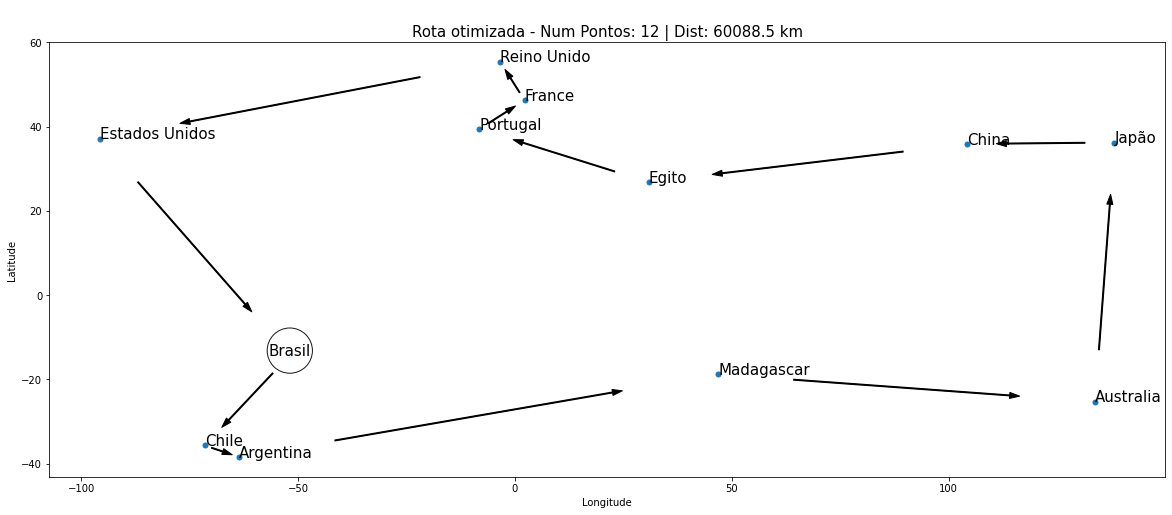

In [7]:
############# Plotagem dos pontos #############
fig, ax = plt.subplots(figsize=(20,8))#numero_turmas, sharex=True, sharey=True, figsize=(15,20))#        
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

x = df['LON']
y = df['LAT']

alpha = 0.5


# transformando uma array em lista de tupla. Essa linha não é obrigatoria, mas quis utiliar tuplas ao inves da lista de coordendas
coord_tupla = map(tuple, df[['PONTO','LON', 'LAT']].values)
coords_list = list(coord_tupla)


################## Pontos ordenados melhor caminho #################################################

coordenadas=df[['LON','LAT']].reindex(rotas[0]).values

ax.scatter(x, y, s = 25)

for i in range(len(df)):    
    if i < len(df):
        start_pos = (coordenadas[i][0],coordenadas[i][1])
        next_node = (coordenadas[i+1][0],coordenadas[i+1][1])      
        ax.annotate("",
                  xy=next_node,   xytext=start_pos,
                  arrowprops=dict(facecolor='black', shrink=0.2, headlength = 10, headwidth= 6, width = 1))
        
################## Indentifica os pontos ##################
#Destacando o ponto inicial
ax.text(coords_list[0][1],coords_list[0][2], df.PONTO[0], color = 'k', fontsize = 15, ha = 'center', bbox=dict(boxstyle='Circle,pad=0.1', facecolor='w', alpha=0.9))


#Nome dos pontos
for i in range(1,len(df)):
    ax.text(coords_list[i][1],coords_list[i][2],coords_list[i][0], color = 'k', fontsize = 15, ha = 'left', bbox=dict(boxstyle='Circle,pad=0.0', facecolor='w', alpha=0))
       


################## Anotar defeitos ##################
props = dict(boxstyle='round', facecolor='orange', alpha=alpha)
ax.set_title('\nRota otimizada - Num Pontos: '+str(len(list_rota)-1)+' | Dist: '+ str(round(distancia,2))+' km', size = 15)
plt.show()


# Plotando no mapa


In [8]:
import folium

m = folium.Map(location=[0,0], 
               zoom_start=2)
#            width=1500,  height=900, tiles = 'CartoDB positron')

point_layer = folium.FeatureGroup(name="Destinos")
Paises = folium.FeatureGroup(name="Paises")


for ponto, lon,lat in coords_list:
    point_layer.add_child(
        
        folium.CircleMarker(
            location=[lat, lon], radius=10,
            popup=str(ponto) + " Lat: " + str(round(lat,4)) + " , Lon: " + str(round(lon,4)), 
            tooltip=str(ponto) + " Lat: " + str(round(lat,4)) + " , Lon: " + str(round(lon,4)),
            fill=True, 
            color='blue',
            fill_opacity=0.7)
    
    ).add_to(m)
    
    Paises.add_child(
            folium.Marker(
            location=[lat, lon], icon=folium.Icon(color="blue")
           )
        
        
    ).add_to(m)
    

folium.LayerControl().add_to(m)  
rota=folium.PolyLine(locations=df_roteirizado[['LAT','LON']],weight= 2, color = 'blue', opacity=0.4) # Traça a rota no mapa
m.add_child(rota)
# m.save('mapa_roteirizado.html')
m